In [1]:
import warnings
import torch
import torchvision
import  numpy as np
import pandas as pd
from skimage import io
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

In [4]:
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 1
num_epochs = 10

In [5]:
# custom dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file:str, root_dir:str, transform:torchvision.transforms=None) -> None:
        super(CustomDataset, self).__init__()
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, y_label
    

In [6]:
import os
os.environ['TORCH_HOME'] = '../pre-trained/' #setting the environment variable

In [7]:
# load pretrained model and modify it
model = torchvision.models.googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to ../pre-trained/hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:05<00:00, 8.88MB/s]


In [8]:
# modifying parameters
for param in model.parameters():
    param.requires_grad = False 
model.fc = nn.Linear(in_features=1024, out_features=num_classes)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
dataset = CustomDataset(
    csv_file='../dataset/cats_dogs.csv',
    root_dir='../dataset/cats_dogs/',
    transform=transforms.ToTensor()
)
# train_set, test_set = torch.utils.data.random_split(dataset, [2000, 5000])
train_set, test_set = torch.utils.data.random_split(dataset, [5, 5])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [11]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # set the data to device
        data = data.to(device)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad() # set all gradients to zero for each batch to avoid storing batch forward calculation
        loss.backward()
        # gradient descent or adam step
        optimizer.step() 
        # add the training loss to the train loses
        train_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # set the model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                prediction = model(x)
                val_loss += criterion(prediction, y).item()
        
        val_loss /= len(test_loader)  # Average validation loss
        val_losses.append(val_loss)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

print("Training and validation completed.")

Epoch [1/10], Step [0/5], Loss: 0.8341
Epoch [1/10], Validation Loss: 0.5803
Epoch [2/10], Step [0/5], Loss: 0.0481
Epoch [2/10], Validation Loss: 0.4637
Epoch [3/10], Step [0/5], Loss: 0.1492
Epoch [3/10], Validation Loss: 0.4353
Epoch [4/10], Step [0/5], Loss: 0.0468
Epoch [4/10], Validation Loss: 0.4148
Epoch [5/10], Step [0/5], Loss: 0.0392
Epoch [5/10], Validation Loss: 0.3911
Epoch [6/10], Step [0/5], Loss: 0.1250
Epoch [6/10], Validation Loss: 0.3736
Epoch [7/10], Step [0/5], Loss: 0.1232
Epoch [7/10], Validation Loss: 0.3567
Epoch [8/10], Step [0/5], Loss: 0.0528
Epoch [8/10], Validation Loss: 0.3471
Epoch [9/10], Step [0/5], Loss: 0.0522
Epoch [9/10], Validation Loss: 0.3466
Epoch [10/10], Step [0/5], Loss: 0.0637
Epoch [10/10], Validation Loss: 0.3507
Training and validation completed.


In [12]:
model_path = f"../models/custom_dataset_fine_tuned.pth"

In [13]:
# save the model
torch.save(model.state_dict(), model_path)

In [14]:
model.load_state_dict(torch.load(model_path))
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
x = np.arange(1, len(train_losses) + 1)

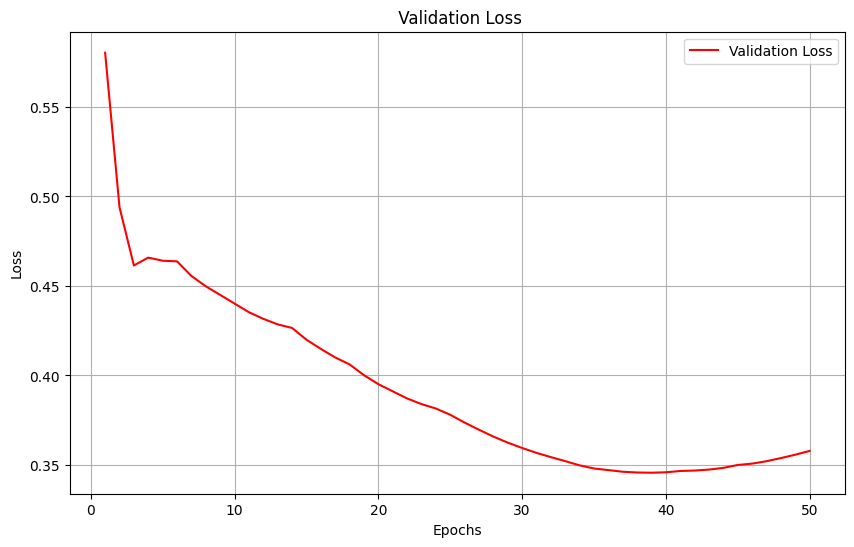

In [16]:
# plot the validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(" Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

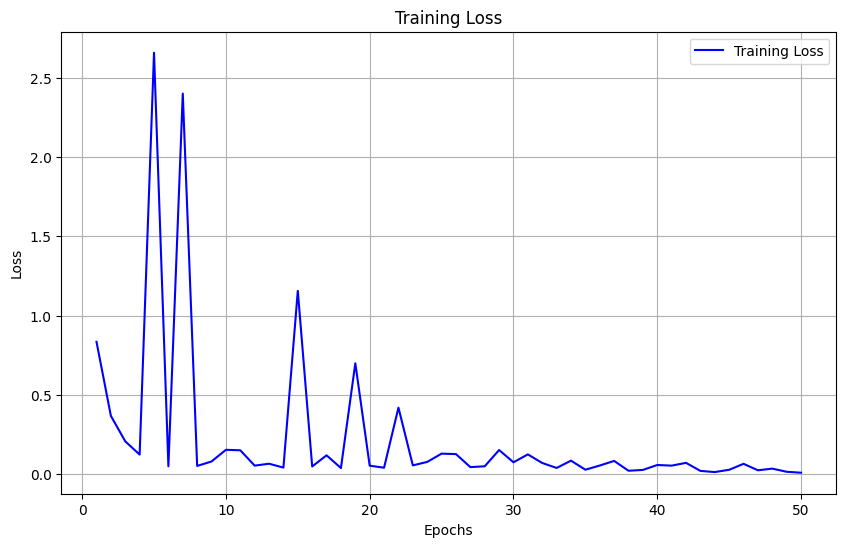

In [17]:
# plot the training
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

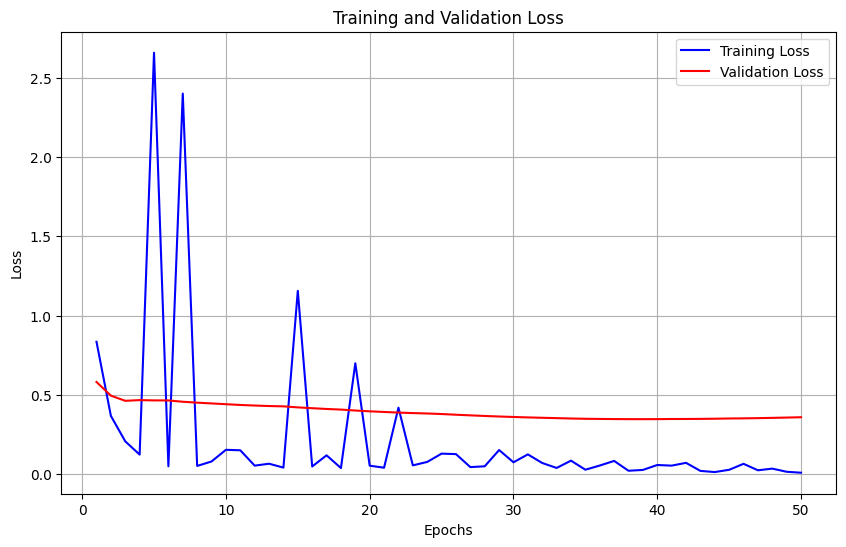

In [18]:
# plot the training and validation loss 
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# check for the accuracy of the model
def check_accuracy(loader, trained_model):
    num_correct = 0
    num_samples = 0
    trained_model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).squeeze(1)
            y = y.to(device)
            pred_scores = trained_model(x)
            _, predictions = pred_scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}")
    print(f"Accuracy: {float(num_correct)/float(num_samples)*100}")

In [20]:
check_accuracy(test_loader, model)

Got 4 / 5 with accuracy 80.0
Accuracy: 80.0
